In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg
from tqdm import tqdm

Using TensorFlow backend.
C:\Users\aalahgholipour160413\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\aalahgholipour160413\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
path = 'imagenet-sample-train/'
dpath = 'C:/Practical_Deep_Learning_or_Coders/deeplearning2/part2-master/'

In [3]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [4]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()
def gram_matrix_b(x):
    x = K.permute_dimensions(x, (0, 3, 1, 2))
    s = K.shape(x)
    feat = K.reshape(x, (s[0], s[1], s[2]*s[3]))
    return K.batch_dot(feat, K.permute_dimensions(feat, (0, 2, 1))
                      ) / K.prod(K.cast(s[1:], K.floatx()))

In [5]:
arr_lr = bcolz.open('trn_resized_72.bc')[:100]
arr_hr = bcolz.open('trn_resized_288.bc')[:100]

In [6]:
import scipy.misc
test=scipy.misc.imresize(arr_hr[0],(400,400))
arr=np.ndarray(shape=(1,400,400,3))
for i in range(len(arr_hr)):
    arr=np.append(arr,scipy.misc.imresize(arr_hr[i],(400,400)).reshape(1,400,400,3), axis=0)

KeyboardInterrupt: 

In [8]:
np.save('arr_400.npy',arr)

In [41]:
arr=np.load('arr_400.npy')

In [42]:
arr=arr[1:101]

In [7]:
arr.shape

(100, 400, 400, 3)

In [7]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization()(x)
    #x = Lambda(lambda x: K.tf.contrib.layers.batch_norm(x))(x)
    return Activation('relu')(x) if act else x

def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    #return merge([x, ip], mode='sum')
    return add([x, ip])

def deconv_block(x, filters, size, shape, stride=(2,2)):
    x = Deconvolution2D(filters, size, size, subsample=stride, 
        border_mode='same', output_shape=(None,)+shape)(x)
    x = BatchNormalization()(x)
    #x = Lambda(lambda x: K.tf.contrib.layers.batch_norm(x))(x)
    return Activation('relu')(x)

def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode='same')(x)
    x = BatchNormalization()(x)
    #x = Lambda(lambda x: K.tf.contrib.layers.batch_norm(x))(x)
    return Activation('relu')(x)

def res_crop_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1), 'valid')
    x = conv_block(x,  nf, 3, (1,1), 'valid', False)
    ip = Lambda(lambda x: x[:, 2:-2, 2:-2])(ip)
    return merge([x, ip], mode='sum')


def get_outp(m, ln): return m.get_layer(f'block{ln}_conv1').output

def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

def content_fn(x): 
    res = 0; n=len(w)
    for i in range(n): res += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return res

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)
        
    def get_output_shape_for(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')
    

In [8]:
#arr_hr=arr
shp = arr_hr.shape[1:]
style = Image.open('rain_princess.jpg')
#style = style.resize(np.divide(style.size,1.5).astype('int32'))
style = scipy.misc.imresize(np.array(style),(288,288))


In [10]:
inp=Input((288,288,3))
x=ReflectionPadding2D((40, 40))(inp)
x=conv_block(x, 64, 9, (1,1))
x=conv_block(x, 64, 3)
x=conv_block(x, 64, 3)
for i in range(5): x=res_crop_block(x)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x=Convolution2D(3, 9, 9, activation='sigmoid', border_mode='same')(x)
outp=Lambda(lambda x: (x)*255)(x)

In [11]:
vgg_inp=Input(shp)
vgg= VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))
#vgg= VGG16_Avg(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))
for l in vgg.layers: l.trainable=False
outputs = {l.name: l.output for l in vgg.layers}

In [41]:
def get_outp(m, ln): return m.get_layer(f'block{ln}_conv2').output
#vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [2,3,4,5]])
vgg_style = Model(vgg_inp, [get_outp(vgg, o) for o in [2]])
vgg_content =  Model(vgg_inp, [get_outp(vgg, o) for o in [2]])

In [42]:
#style_targs = [K.variable(o) for o in
#               vgg_content.predict(np.expand_dims(style,0))]
style_targs = [K.variable(o) for o in
               vgg_style.predict(np.expand_dims(style,0))]
#content_targs = [K.variable(o) for o in
#                 vgg_content.predict(np.expand_dims(outp,0))]

In [43]:
#vgg1 = vgg_content(vgg_inp)
#vgg2 = vgg_content(outp)
global vgg_content1, vgg_content2, vgg_style2
vgg_content1 = vgg_content(vgg_inp)
vgg_content2 = vgg_content(outp)
vgg_style2 = vgg_style(outp)

In [44]:
w=[1]
def tot_loss(x):
    loss = 0; n = len(style_targs)
    for i in range(n):
        loss += mean_sqr_b(gram_matrix(x[i]) - gram_matrix(style_targs[i])) / 2.
    for i in range(1):
        loss += mean_sqr_b(vgg_content1[i]-vgg_content2[i]) * w[i]
    return loss

In [45]:
loss = Lambda(tot_loss)(vgg_style2)
#loss = 0
#loss += mean_sqr_b(vgg_content1-vgg_content2) 
m_style = Model([inp, vgg_inp], loss)
targ = np.zeros((arr_hr.shape[0], 1))

In [25]:
m_style.compile('adam', 'mae')
m_style.fit([arr_hr, arr_hr], targ, 1, 1)

Epoch 1/1
100/100 [==============================] - ETA: 949s - loss: 1708.69 - ETA: 511s - loss: 1450.25 - ETA: 365s - loss: 1346.33 - ETA: 291s - loss: 1278.39 - ETA: 246s - loss: 1228.86 - ETA: 216s - loss: 1210.51 - ETA: 195s - loss: 1192.32 - ETA: 178s - loss: 1178.10 - ETA: 166s - loss: 1161.70 - ETA: 155s - loss: 1150.25 - ETA: 146s - loss: 1136.06 - ETA: 139s - loss: 1124.33 - ETA: 132s - loss: 1113.95 - ETA: 127s - loss: 1102.88 - ETA: 122s - loss: 1093.75 - ETA: 117s - loss: 1089.54 - ETA: 113s - loss: 1089.52 - ETA: 109s - loss: 1089.78 - ETA: 106s - loss: 1090.74 - ETA: 103s - loss: 1087.28 - ETA: 100s - loss: 1084.24 - ETA: 97s - loss: 1081.1503 - ETA: 95s - loss: 1079.870 - ETA: 92s - loss: 1078.285 - ETA: 90s - loss: 1074.707 - ETA: 88s - loss: 1072.132 - ETA: 86s - loss: 1072.256 - ETA: 84s - loss: 1067.897 - ETA: 82s - loss: 1065.954 - ETA: 80s - loss: 1065.500 - ETA: 78s - loss: 1065.968 - ETA: 76s - loss: 1063.576 - ETA: 75s - loss: 1060.428 - ETA: 73s - loss: 1061.

In [53]:
K.set_value(m_style.optimizer.lr, 1e-4)
m_style.fit([arr_hr, arr_hr], targ, 2, 10)

Epoch 1/10
100/100 [==============================] - ETA: 80s - loss: 723.26 - ETA: 78s - loss: 778.40 - ETA: 77s - loss: 768.94 - ETA: 75s - loss: 757.77 - ETA: 73s - loss: 750.51 - ETA: 72s - loss: 766.52 - ETA: 70s - loss: 758.23 - ETA: 68s - loss: 753.39 - ETA: 66s - loss: 748.90 - ETA: 65s - loss: 745.49 - ETA: 63s - loss: 742.87 - ETA: 62s - loss: 741.25 - ETA: 60s - loss: 740.47 - ETA: 58s - loss: 737.48 - ETA: 57s - loss: 737.30 - ETA: 55s - loss: 737.11 - ETA: 54s - loss: 735.37 - ETA: 52s - loss: 734.92 - ETA: 50s - loss: 736.15 - ETA: 49s - loss: 735.21 - ETA: 47s - loss: 735.54 - ETA: 46s - loss: 734.93 - ETA: 44s - loss: 733.45 - ETA: 42s - loss: 732.56 - ETA: 41s - loss: 731.64 - ETA: 39s - loss: 730.92 - ETA: 37s - loss: 729.57 - ETA: 36s - loss: 730.37 - ETA: 34s - loss: 729.04 - ETA: 33s - loss: 728.71 - ETA: 31s - loss: 728.17 - ETA: 29s - loss: 727.56 - ETA: 28s - loss: 728.24 - ETA: 26s - loss: 728.07 - ETA: 24s - loss: 728.73 - ETA: 23s - loss: 729.87 - ETA: 21s -

In [54]:
top_model = Model(inp, outp)

In [38]:
arr_hr = bcolz.open('trn_resized_288.bc')[:9000]

In [37]:
%time p = top_model.predict(arr_hr[1000:1002])

Wall time: 805 ms


In [55]:
t = Image.open('chicago.jpg')
#t = t.resize(np.divide(t.size,1.6).astype('int32'))
#t = np.array(t)[:shp[0], :shp[1], :shp[2]]
t = scipy.misc.imresize(np.array(t),(400,400))
p = top_model.predict(t.reshape(1,400,400,3))

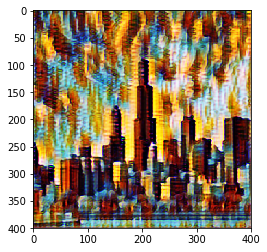

In [58]:
plt.imshow(np.round(p[0]).astype('uint8'));

In [59]:
import scipy.misc
scipy.misc.imsave('test.jpg', p[0])

In [20]:
top_model.save('test_fast_style_1000_new.h5')

In [9]:
top_model.load_weights('test_fast_style_1000_new.h5')